In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
folder = '/Users/hoale/Code/MA_Weather/'
df = pd.DataFrame()

for dirname, _, filenames in os.walk(folder):
    for filename in filenames:
        if filename.endswith('.csv'):
            dfx = pd.read_csv(os.path.join(dirname, filename))
            df = pd.concat([df, dfx], axis=0)
df.head(5)

,EVENT_ID,CZ_NAME_STR,BEGIN_LOCATION,BEGIN_DATE,BEGIN_TIME,EVENT_TYPE,MAGNITUDE,TOR_F_SCALE,DEATHS_DIRECT,INJURIES_DIRECT,...,END_LOCATION,END_DATE,END_TIME,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EVENT_NARRATIVE,EPISODE_NARRATIVE,ABSOLUTE_ROWNUMBER
0,1155403,NORTHERN BERKSHIRE (ZONE),,01/06/2024,1600,Heavy Snow,,,0,0,...,,01/07/2024,1900,,,,,NaN,An area of low pressure slowly tracking up and...,1
1,1155404,SOUTHERN BERKSHIRE (ZONE),,01/06/2024,1600,Heavy Snow,,,0,0,...,,01/07/2024,1900,,,,,NaN,An area of low pressure slowly tracking up and...,2
2,1147150,EASTERN FRANKLIN (ZONE),,01/06/2024,2300,Heavy Snow,,,0,0,...,,01/07/2024,1700,,,,,Generally 8 to 15 inches of snow fell. Some hi...,A strong storm moved up the east coast passing...,3
3,1147157,EASTERN HAMPSHIRE (ZONE),,01/06/2024,2300,Heavy Snow,,,0,0,...,,01/07/2024,1700,,,,,Generally 10 to 15 inches of snow fell. Some a...,A strong storm moved up the east coast passing...,4
4,1147149,WESTERN FRANKLIN (ZONE),,01/06/2024,2300,Heavy Snow,,,0,0,...,,01/07/2024,1600,,,,,Generally 8 to 14 inches of snow fell. Some sn...,A strong storm moved up the east coast passing...,5


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3503 entries, 0 to 366
Data columns (total 39 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   EVENT_ID             3503 non-null   int64 
 1   CZ_NAME_STR          3503 non-null   object
 2   BEGIN_LOCATION       3503 non-null   object
 3   BEGIN_DATE           3503 non-null   object
 4   BEGIN_TIME           3503 non-null   int64 
 5   EVENT_TYPE           3503 non-null   object
 6   MAGNITUDE            3503 non-null   object
 7   TOR_F_SCALE          3503 non-null   object
 8   DEATHS_DIRECT        3503 non-null   int64 
 9   INJURIES_DIRECT      3503 non-null   int64 
 10  DAMAGE_PROPERTY_NUM  3503 non-null   int64 
 11  DAMAGE_CROPS_NUM     3503 non-null   int64 
 12  STATE_ABBR           3503 non-null   object
 13  CZ_TIMEZONE          3503 non-null   object
 14  MAGNITUDE_TYPE       3503 non-null   object
 15  EPISODE_ID           3503 non-null   int64 
 16  CZ_TYPE     

In [3]:
df.columns = df.columns.astype(str).str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [4]:
# Standardize the time columns
df['begin_time'] = df['begin_time'].astype(str)
df['end_time'] = df['end_time'].astype(str)
df['begin_time'] = df['begin_time'].str.pad(width=4, side='left', fillchar='0')
df['end_time'] = df['end_time'].str.pad(width=4, side='left', fillchar='0')

# Change date and time format
df['begin_date'] = pd.to_datetime(df['begin_date'])
df['end_date'] = pd.to_datetime(df['end_date'])
df['begin_time'] = pd.to_datetime(df['begin_time'], format='%H%M')
df['end_time'] = pd.to_datetime(df['end_time'], format='%H%M')

# Create new features
df['month'] = df['begin_date'].dt.month
df['year'] = df['begin_date'].dt.year
df['day'] = df['begin_date'].dt.day
df['begin'] = df['begin_date'] + pd.to_timedelta(df['begin_time'].dt.hour, unit='h') + pd.to_timedelta(df['begin_time'].dt.minute, unit='m')
df['end'] = df['end_date'] + pd.to_timedelta(df['end_time'].dt.hour, unit='h') + pd.to_timedelta(df['end_time'].dt.minute, unit='m')
df['duration'] = df['end'] - df['begin']
df['type'] = np.where((df['episode_narrative'].str.contains('heavy snow', case=False, na=False)) | (df['event_type']=='Heavy Snow'), 'Heavy Snow', 'Other')

In [5]:
# Grouping events
wind_events = ['High Wind', 'Strong Wind']
flood_events = ['Flood', 'Flash Flood', 'Coastal Flood', 'Heavy Rain', 'Tropical Storm', 'Debris Flow',]
thunderstorm_events = ['Thunderstorm Wind', 'Tornado', 'Funnel Cloud', 'Lightning']
cold_events = ['Frost/Freeze', 'Winter Weather', 'Winter Storm','Extreme Cold/Wind Chill','Cold/Wind Chill',]
snow_events = ['Heavy Snow', 'Snow', 'Blizzard', 'Winter Storm', 'Hail', 'Ice Storm', 'Sleet']
heat_events = ['Heat', 'Drought', 'Wildfire']
event_dict = {'Wind': wind_events, 
              'Flood': flood_events, 
              'Thunderstorm': thunderstorm_events, 
              'Extreme Cold': cold_events, 
              'Snow': snow_events, 
              'Heat': heat_events}
# Create a reverse dictionary to map event types to their groups
reverse_event_dict = {event: group for group, events in event_dict.items() for event in events}

# Map the event types to their groups
df['event_group'] = df['event_type'].map(reverse_event_dict).fillna('Other')


In [6]:
# Grouping location
df['location'] = df['cz_name_str'].str.replace(' (ZONE)', '').replace(' CO.', '', regex=True).str.split(' ').str[-1].str.capitalize()
df['location'] = df['location'].str.replace('Middlesexnty','Middlesex') # Fix typo

In [7]:
# Grouping months to seasons
seasons = {'Winter': [12, 1, 2], 'Spring': [3, 4, 5], 'Summer': [6, 7, 8], 'Fall': [9, 10, 11]}
df['season'] = df['month'].apply(lambda x: next(season for season, months in seasons.items() if x in months))

# Take a first look at the overall

## Which events happened the most in MA?

There are 6 main types of events being reported. Of which, thunderstorm was the most popular event.

In [8]:
# Set the order of the event types and theme
sns.set_palette('bright')
sns.set_theme(font_scale=1.2, style='dark',)
order = ['Thunderstorm', 'Wind', 'Flood', 'Extreme Cold', 'Snow', 'Heat']

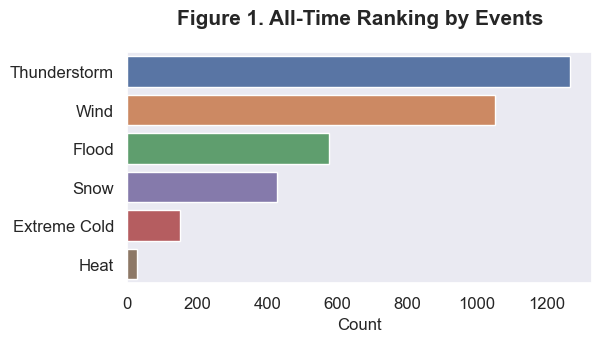

In [9]:
plt.figure(figsize=(6, 3))
sns.barplot(y=df['event_group'].value_counts().index, x=df['event_group'].value_counts().values, hue=df['event_group'].value_counts().index, dodge=False, hue_order=order)
plt.ylabel('')
plt.xlabel('Count', fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Figure 1. All-Time Ranking by Events', pad=20, fontdict={'fontsize': 15, 'fontweight': 'bold'})
plt.show()

## What are the trends of events?

Total number of events decreased by about 50%, mostly with wind-related events. It could be that it is less windy, or that we no longer report as much wind events as before.
(2024 data is not up to date, i.e. lacking data after August 31st) 

There was a lot more floods in 2023 compared to prior years. However, the amount of floods decreased in 2024.

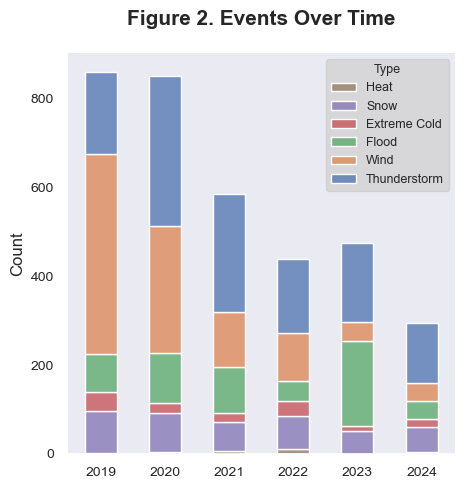

In [24]:
sns.displot(x=df['year'], discrete=True, shrink=.5, hue=df['event_group'], multiple='stack', legend=False, hue_order=order)
plt.ylabel('Count', fontsize=12)
plt.xlabel('')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.legend(title='Type', loc='upper right', fontsize=9, title_fontsize=9, facecolor='lightgrey', 
           labels=['Heat', 'Snow', 'Extreme Cold', 'Flood', 'Wind', 'Thunderstorm'])
plt.title('Figure 2. Events Over Time', pad=20, fontdict={'fontsize': 15, 'fontweight': 'bold'})
plt.show()


## Which areas had the most events?

Worcester, Berkshire and Middlesex stood out with the most events. Espcially, it looked really "extreme" in Berkshire where there were both heat and extreme cold conditions, not to mention floods and snows. 

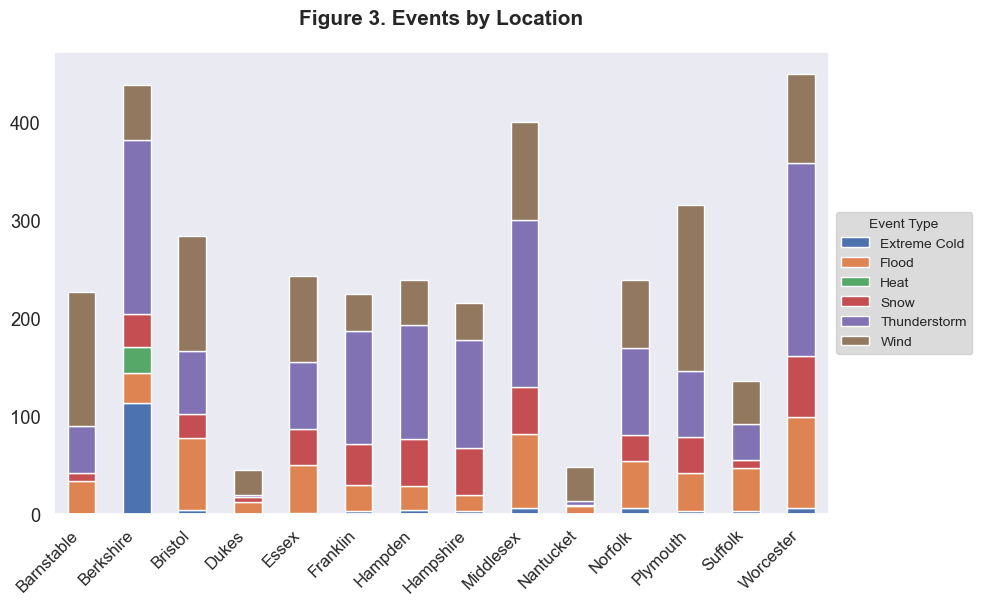

In [11]:
df.groupby('location')['event_group'].value_counts(normalize=False).unstack().plot(kind='bar', stacked=True, figsize=(10, 6),)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Event Type', fontsize=10, title_fontsize=10, facecolor='lightgrey')
plt.xlabel('')
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.title('Figure 3. Events by Location', pad=20, fontdict={'fontsize': 15, 'fontweight': 'bold'})
plt.show()

---

# Let's take a closer look at snow events!

## Which areas have the most snow events?

Snow was everywhere, every season! Be prepared to have winter storms, including blizzards and ice storms, or at least heavey snow no matter where you live in this state.

Nantucket seemed like the place to live for those who don't love snow. Although there were hails in the summer, no other snow events happened during the year. It's not surprising as this is the smallest county with only one city.

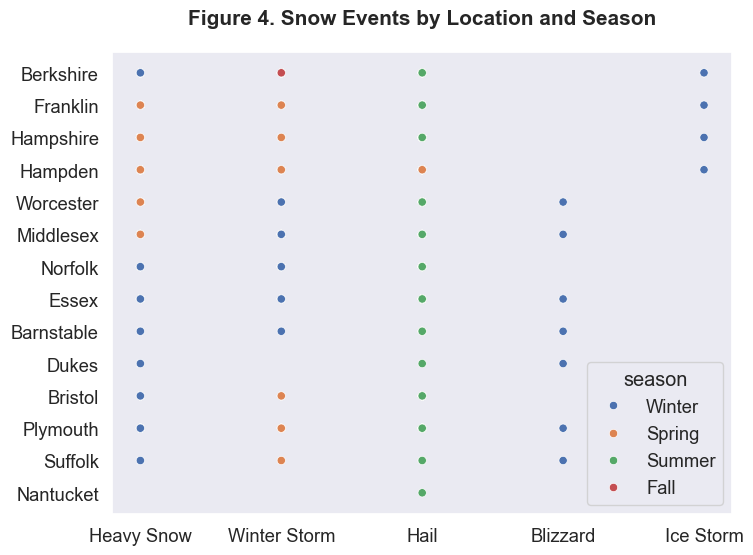

In [12]:
snowdf = df[df['event_group']=='Snow']
plt.figure(figsize=(8, 6))
sns.scatterplot(y=snowdf['location'], x=snowdf['event_type'], hue=snowdf['season'], legend='brief', )
plt.xlabel('')
plt.ylabel('')
plt.title('Figure 4. Snow Events by Location and Season', pad=20, fontdict={'fontsize': 15, 'fontweight': 'bold'})
plt.show()

## How long do heavy snow events last?

The duration of heavy snow events varied from a few hours to almost 2 days. The average duration increased slightly from 2020 to 2023, each year by about 2 hours. This trend likely will continue in 2024.

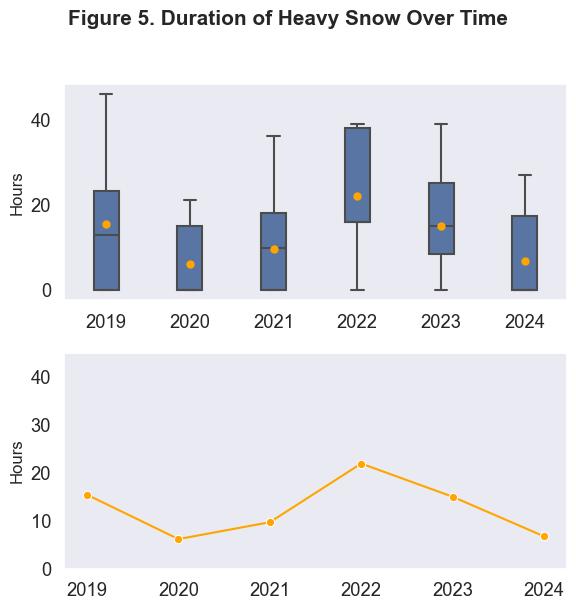

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(6, 6), )
sns.boxplot(x=snowdf['year'], y=snowdf['duration'].dt.total_seconds()/3600, width=0.3, linewidth=1.5,  
            meanline=False, showmeans=True, meanprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'orange', 'markeredgecolor': 'orange'}, ax=axs[0])
sns.lineplot(x=snowdf['year'], y=snowdf['duration'].dt.total_seconds()/3600, estimator='mean', errorbar=None, marker='o', ax=axs[1], color='orange',)

axs[0].set_ylabel('Hours', fontsize=12)
axs[0].set_xlabel('')

axs[1].set_ylim(0, 45)
axs[1].set_ylabel('Hours', fontsize=12)
axs[1].set_xlabel('')

fig.suptitle('Figure 5. Duration of Heavy Snow Over Time', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## When does heavy snow usually start?

Yes, in the winter, most often in January. Sometimes we saw heavy snow in the spring as well, and once in 2020 we saw a heavy snow in October.

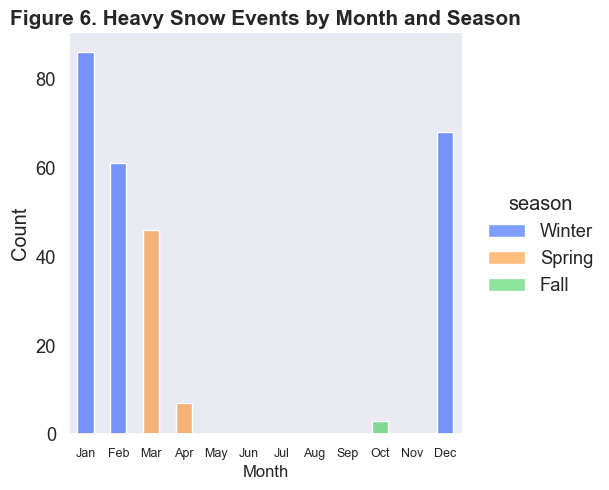

In [26]:
hs = df[df['type']=='Heavy Snow']
sns.displot(x=hs['month'], discrete=True, legend=True, hue=hs['season'], shrink=.5, palette='bright',)
plt.xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=9)
plt.xlabel('Month', fontsize=12)
plt.xlim(0.5, 12.5)
plt.title('Figure 6. Heavy Snow Events by Month and Season', fontdict={'size': 15, 'weight': 'bold'},)
plt.show()

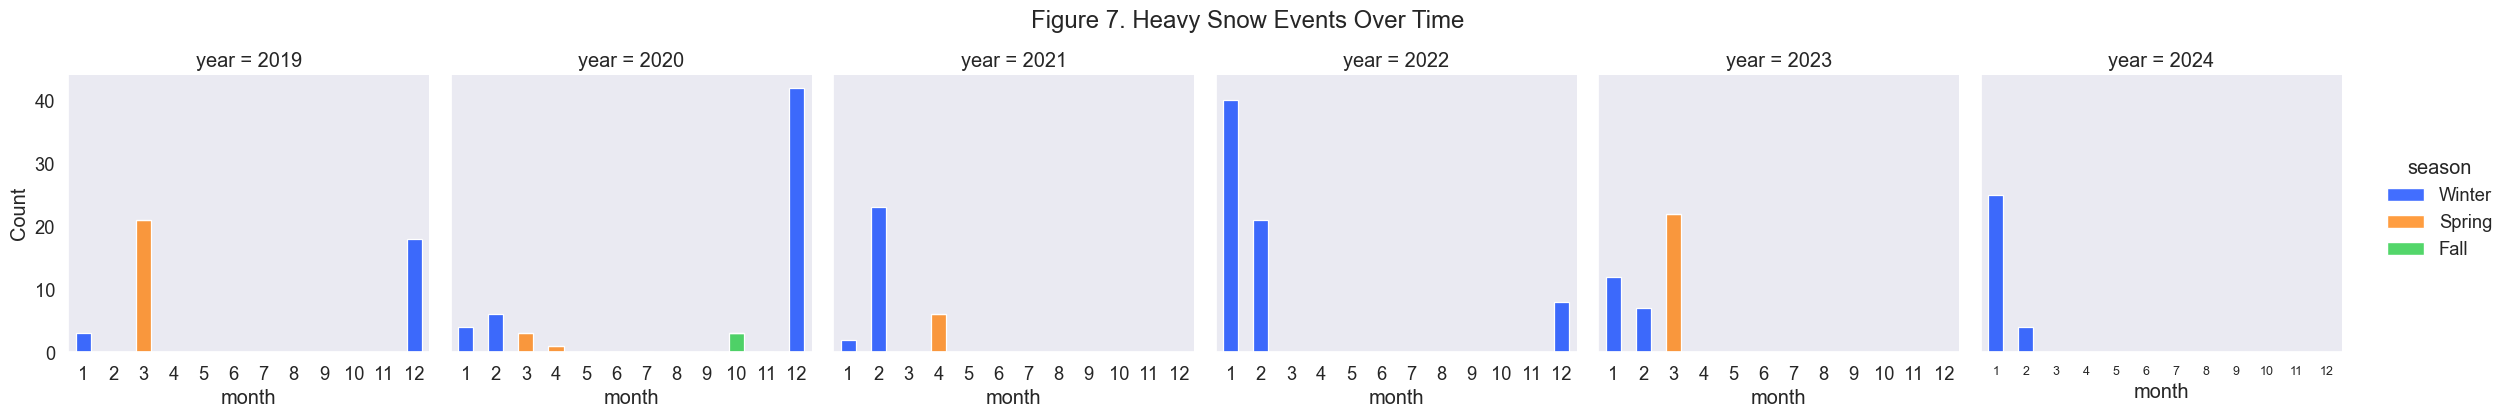

In [36]:
hs = df[df['type']=='Heavy Snow']
sns.displot(x=hs['month'], discrete=True, legend=True, hue=hs['season'], shrink=.5, palette='bright', multiple='stack', col=hs['year'], col_wrap=6, height=4, aspect=1)
plt.xticks(np.arange(1, 13), fontsize=9)
plt.xlim(0.5, 12.5)
plt.suptitle('Figure 7. Heavy Snow Events Over Time', fontdict={'size': 20, 'weight': 'bold'}, y=1.05)
plt.show()

---


Based on the provided data and analysis, here are some summary insights:

1. **Data Overview**:
    - The dataset contains weather event data for Massachusetts, with 3503 entries and 49 columns.
    - The data includes information such as event type, location, date, time, magnitude, and narrative descriptions.

2. **Event Types**:
    - The events are categorized into six main groups: Wind, Flood, Thunderstorm, Extreme Cold, Snow, and Heat.
    - Thunderstorm events are the most common, followed by Wind and Flood events.

3. **Time Standardization and Feature Creation**:
    - The time columns have been standardized and new features such as month, year, day, and duration have been created.
    - Events have been grouped into categories based on their type.

4. **Location Grouping**:
    - Locations have been standardized and grouped to remove inconsistencies and typos.

5. **Seasonal Grouping**:
    - Months have been grouped into seasons: Winter, Spring, Summer, and Fall.

6. **Event Trends**:
    - The total number of events has decreased by about 50%, with a significant reduction in wind-related events.
    - Flood events increased in 2023 but decreased in 2024.

7. **Event Distribution by Location**:
    - Worcester, Berkshire, and Middlesex counties have the highest number of events.
    - Berkshire county experiences a wide range of extreme weather conditions.

8. **Snow Events**:
    - Snow events are prevalent across all locations and seasons, with Nantucket being an exception with fewer snow events.
    - The duration of heavy snow events has increased slightly over the years.
    - Heavy snow events typically start in winter, most often in January, but can also occur in spring and occasionally in fall.

9. **Visualizations**:
    - Various visualizations have been created to analyze the distribution and trends of events over time and by location.

These insights provide a comprehensive understanding of the weather events in Massachusetts, highlighting trends, seasonal patterns, and regional differences.